# Importing Libraries

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.gridspec import GridSpec
from matplotlib import pyplot as plt
%matplotlib inline

from scipy import stats
from scipy.special import boxcox1p

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

# Load specific evaluation tools
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

C:\Users\namkyu.im\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
C:\Users\namkyu.im\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


# Getting Dataset

In [5]:
features = pd.read_csv('features.csv')
train = pd.read_csv('train.csv')
stores = pd.read_csv('stores.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sampleSubmission.csv')

# EDA and Data Cleaning

In [7]:
print(features.shape)
features.info()
features.head(10)

(8190, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False
5,1,2010-03-12,57.79,2.667,NaN,NaN,NaN,NaN,NaN,211.380643,8.106,False
6,1,2010-03-19,54.58,2.720,NaN,NaN,NaN,NaN,NaN,211.215635,8.106,False
7,1,2010-03-26,51.45,2.732,NaN,NaN,NaN,NaN,NaN,211.018042,8.106,False
8,1,2010-04-02,62.27,2.719,NaN,NaN,NaN,NaN,NaN,210.820450,7.808,False
9,1,2010-04-09,65.86,2.770,NaN,NaN,NaN,NaN,NaN,210.622857,7.808,False


In [8]:
print(train.shape)
train.info()
train.head()

(421570, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [10]:
print(stores.shape)
stores.info()
stores.head()

(45, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [11]:
print(test.shape)
test.info()
test.head()

(115064, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115064 entries, 0 to 115063
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Store      115064 non-null  int64 
 1   Dept       115064 non-null  int64 
 2   Date       115064 non-null  object
 3   IsHoliday  115064 non-null  bool  
dtypes: bool(1), int64(2), object(1)
memory usage: 2.7+ MB


,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


In [12]:
print(sample_submission.shape)
sample_submission.info()
sample_submission.head()

(115064, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115064 entries, 0 to 115063
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   Id            115064 non-null  object
 1   Weekly_Sales  115064 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ MB


,Id,Weekly_Sales
0,1_1_2012-11-02,0
1,1_1_2012-11-09,0
2,1_1_2012-11-16,0
3,1_1_2012-11-23,0
4,1_1_2012-11-30,0


# Merging features and store data

In [14]:
feat_store = features.merge(stores, how='inner', on ='Store')
feat_store.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315


In [15]:
feat_store.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8190 entries, 0 to 8189
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
 12  Type          8190 non-null   object 
 13  Size          8190 non-null   int64  
dtypes: bool(1), float64(9), int64(2), object(2)
memory usage: 903.8+ KB


# Comparison Datatypes: Train vs Test

In [16]:
pd.DataFrame({'Type_Train': train.dtypes, 'Type_Test': test.dtypes})

,Type_Train,Type_Test
Date,object,object
Dept,int64,int64
IsHoliday,bool,bool
Store,int64,int64
Weekly_Sales,float64,NaN


# Change the Date to datetime

In [19]:
feat_store['Date'] = pd.to_datetime(feat_store['Date'])
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

In [20]:
feat_store.dtypes

Store                    int64
Date            datetime64[ns]
Temperature            float64
Fuel_Price             float64
MarkDown1              float64
MarkDown2              float64
MarkDown3              float64
MarkDown4              float64
MarkDown5              float64
CPI                    float64
Unemployment           float64
IsHoliday                 bool
Type                    object
Size                     int64
dtype: object

In [22]:
feat_store['Year'] = feat_store['Date'].dt.year
feat_store['Week'] = feat_store['Date'].dt.week

In [23]:
print(feat_store.shape)
feat_store[['Date','Year','Week']].head(10)

(8190, 16)


,Date,Year,Week
0,2010-02-05,2010,5
1,2010-02-12,2010,6
2,2010-02-19,2010,7
3,2010-02-26,2010,8
4,2010-03-05,2010,9
5,2010-03-12,2010,10
6,2010-03-19,2010,11
7,2010-03-26,2010,12
8,2010-04-02,2010,13
9,2010-04-09,2010,14


In [24]:
feat_store.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size,Year,Week
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,2010,5
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315,2010,6
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315,2010,7
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315,2010,8
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315,2010,9


In [25]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [26]:
test.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


## Merge two dataset with with feat_store - keys are Store, Date and IsHoliday

In [28]:
train_detail = train.merge(feat_store, how = 'inner', 
           on = ['Store', 'Date', 'IsHoliday']).sort_values(by = ['Store', 'Dept', 'Date']).reset_index(drop=True)

In [29]:
print(train_detail.shape)
train_detail.info()
train_detail.head()

(421570, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
 5   Temperature   421570 non-null  float64       
 6   Fuel_Price    421570 non-null  float64       
 7   MarkDown1     150681 non-null  float64       
 8   MarkDown2     111248 non-null  float64       
 9   MarkDown3     137091 non-null  float64       
 10  MarkDown4     134967 non-null  float64       
 11  MarkDown5     151432 non-null  float64       
 12  CPI           421570 non-null  float64       
 13  Unemployment  421570 non-null  float64       
 14  Type          421570 non-null  object        
 15  Size

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Year,Week
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,2010,5
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315,2010,6
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315,2010,7
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315,2010,8
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315,2010,9


In [30]:
test_detail = test.merge(feat_store, how = 'inner', 
           on = ['Store', 'Date', 'IsHoliday']).sort_values(by = ['Store', 'Dept', 'Date']).reset_index(drop=True)

print(test_detail.shape)
test_detail.info()
test_detail.head()

(115064, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115064 entries, 0 to 115063
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         115064 non-null  int64         
 1   Dept          115064 non-null  int64         
 2   Date          115064 non-null  datetime64[ns]
 3   IsHoliday     115064 non-null  bool          
 4   Temperature   115064 non-null  float64       
 5   Fuel_Price    115064 non-null  float64       
 6   MarkDown1     114915 non-null  float64       
 7   MarkDown2     86437 non-null   float64       
 8   MarkDown3     105235 non-null  float64       
 9   MarkDown4     102176 non-null  float64       
 10  MarkDown5     115064 non-null  float64       
 11  CPI           76902 non-null   float64       
 12  Unemployment  76902 non-null   float64       
 13  Type          115064 non-null  object        
 14  Size          115064 non-null  int64         
 15  Year

,Store,Dept,Date,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Year,Week
0,1,1,2012-11-02,False,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,A,151315,2012,44
1,1,1,2012-11-09,False,61.24,3.314,11421.32,3370.89,40.28,4646.79,6154.16,223.481307,6.573,A,151315,2012,45
2,1,1,2012-11-16,False,52.92,3.252,9696.28,292.10,103.78,1133.15,6612.69,223.512911,6.573,A,151315,2012,46
3,1,1,2012-11-23,True,56.23,3.211,883.59,4.17,74910.32,209.91,303.32,223.561947,6.573,A,151315,2012,47
4,1,1,2012-11-30,False,52.34,3.207,2460.03,NaN,3838.35,150.57,6966.34,223.610984,6.573,A,151315,2012,48


In [31]:
train_detail.isnull().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
Type                 0
Size                 0
Year                 0
Week                 0
dtype: int64

In [32]:
test_detail.isnull().sum()

Store               0
Dept                0
Date                0
IsHoliday           0
Temperature         0
Fuel_Price          0
MarkDown1         149
MarkDown2       28627
MarkDown3        9829
MarkDown4       12888
MarkDown5           0
CPI             38162
Unemployment    38162
Type                0
Size                0
Year                0
Week                0
dtype: int64

## There are so many null values in the Markdowns - shouldn't consider to input the modeling

# Holiday Analysis

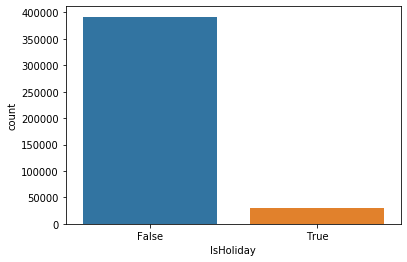

In [34]:
sns.countplot(data= train_detail, x = 'IsHoliday')

In [37]:
pysqldf("""
SELECT
    T.*,
    case
        when ROW_NUMBER() OVER(partition by Year order by week) = 1 then 'Super Bowl'
        when ROW_NUMBER() OVER(partition by Year order by week) = 2 then 'Labor Day'
        when ROW_NUMBER() OVER(partition by Year order by week) = 3 then 'Thanksgiving'
        when ROW_NUMBER() OVER(partition by Year order by week) = 4 then 'Christmas'
    end as Holyday,
    case
        when ROW_NUMBER() OVER(partition by Year order by week) = 1 then 'Sunday'
        when ROW_NUMBER() OVER(partition by Year order by week) = 2 then 'Monday'
        when ROW_NUMBER() OVER(partition by Year order by week) = 3 then 'Thursday'
        when ROW_NUMBER() OVER(partition by Year order by week) = 4 and Year = 2010 then 'Saturday'
        when ROW_NUMBER() OVER(partition by Year order by week) = 4 and Year = 2011 then 'Sunday'
        when ROW_NUMBER() OVER(partition by Year order by week) = 4 and Year = 2012 then 'Tuesday'
    end as Day
    from(
        SELECT DISTINCT
            Year,
            Week,
            case 
                when Date <= '2012-11-01' then 'Train Data' else 'Test Data' 
            end as Data_type
        FROM feat_store
        WHERE IsHoliday = True) as T""")

,Year,Week,Data_type,Holyday,Day
0,2010,6,Train Data,Super Bowl,Sunday
1,2010,36,Train Data,Labor Day,Monday
2,2010,47,Train Data,Thanksgiving,Thursday
3,2010,52,Train Data,Christmas,Saturday
4,2011,6,Train Data,Super Bowl,Sunday
5,2011,36,Train Data,Labor Day,Monday
6,2011,47,Train Data,Thanksgiving,Thursday
7,2011,52,Train Data,Christmas,Sunday
8,2012,6,Train Data,Super Bowl,Sunday
9,2012,36,Train Data,Labor Day,Monday


#### Interesting facts

1. All holidays are on the same week
2. Test data doesn't have Labor Day, so this holiday is not relevant


# Average Weekly Sales by Year

In [54]:
weekly_sales_2010 = train_detail[train_detail['Year'] == 2010]['Weekly_Sales'].groupby(train_detail['Week']).mean()
weekly_sales_2011 = train_detail[train_detail['Year'] == 2011]['Weekly_Sales'].groupby(train_detail['Week']).mean()
weekly_sales_2012 = train_detail[train_detail['Year'] == 2012]['Weekly_Sales'].groupby(train_detail['Week']).mean()

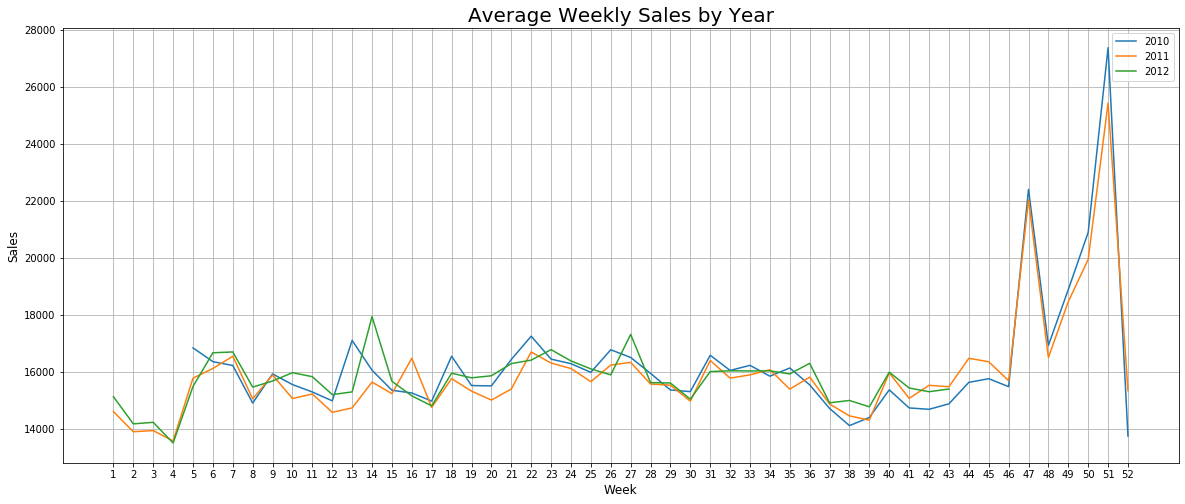

In [61]:
plt.figure(figsize = (20,8))
sns.lineplot(weekly_sales_2010.index, weekly_sales_2010.values)
sns.lineplot(weekly_sales_2011.index, weekly_sales_2011.values)
sns.lineplot(weekly_sales_2012.index, weekly_sales_2012.values)
plt.grid()
plt.xticks(np.arange(1, 53, step=1))
plt.legend(['2010','2011','2012'], loc = 'best')
plt.title('Average Weekly Sales by Year',fontsize = 20)
plt.xlabel('Week',fontsize = 12)
plt.ylabel('Sales',fontsize = 12)
plt.show()

#### We missed Easter as holiday but it falls on different weeks per year

1. 2010 - week13
2. 2011 - week16
3. 2012 - week14
4. test set - Week13 is 2013

Update the True to the each year

In [66]:
train_detail.loc[(train_detail.Year==2010) & (train_detail.Week==13), 'IsHoliday'] = True

In [67]:
train_detail.loc[(train_detail.Year==2011) & (train_detail.Week==16), 'IsHoliday'] = True
train_detail.loc[(train_detail.Year==2012) & (train_detail.Week==14), 'IsHoliday'] = True
test_detail.loc[(test_detail.Year==2013) & (test_detail.Week==13), 'IsHoliday'] = True

In [69]:
train_detail.loc[(train_detail.Year==2011) & (train_detail.Week==16),'IsHoliday']

63        True
206       True
349       True
492       True
635       True
          ... 
420933    True
421067    True
421210    True
421355    True
421490    True
Name: IsHoliday, Length: 2955, dtype: bool

In [72]:
weekly_sales_mean = train_detail['Weekly_Sales'].groupby(train_detail['Date']).mean()
weekly_sales_median = train_detail['Weekly_Sales'].groupby(train_detail['Date']).median()



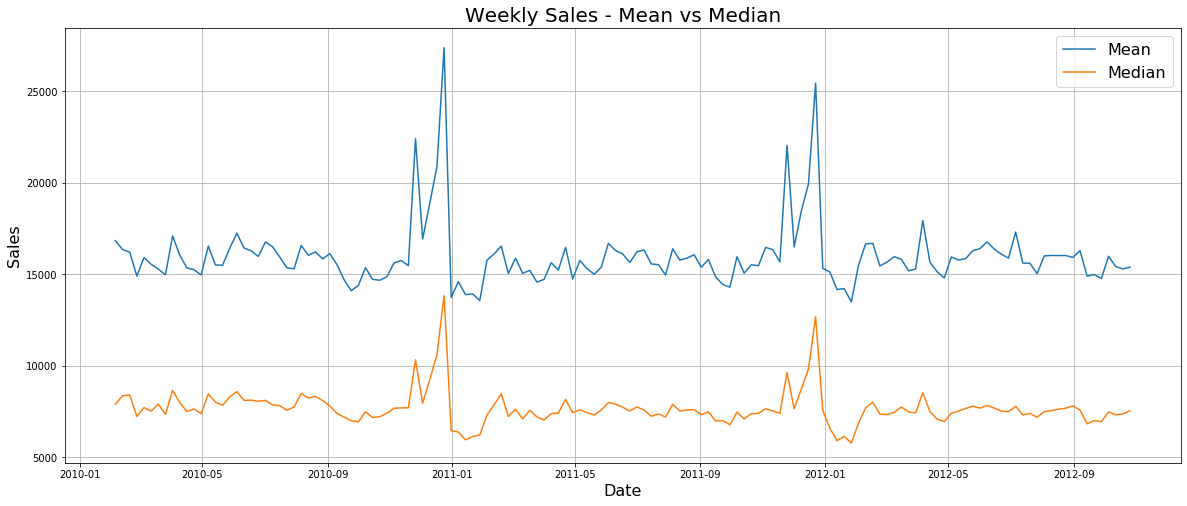

In [74]:
plt.figure(figsize =(20,8))
sns.lineplot(weekly_sales_mean.index, weekly_sales_mean.values)
sns.lineplot(weekly_sales_median.index, weekly_sales_median.values)
plt.grid()
plt.legend(['Mean','Median'], loc ='best', fontsize=16)
plt.title('Weekly Sales - Mean vs Median', fontsize = 20)
plt.xlabel('Date', fontsize = 16)
plt.ylabel('Sales', fontsize = 16)
plt.show()

# Avg Sales per Store and Department

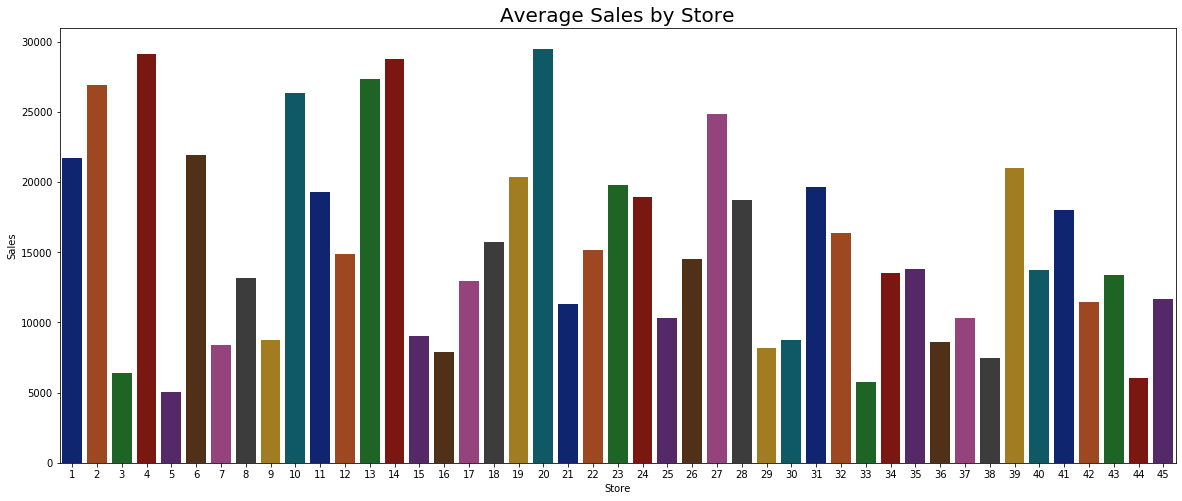

In [77]:
weekly_sales_store = train_detail['Weekly_Sales'].groupby(train_detail['Store']).mean()

plt.figure(figsize = (20,8))
sns.barplot(weekly_sales_store.index, weekly_sales_store.values, palette = 'dark')
plt.title('Average Sales by Store', fontsize=20)
plt.xlabel('Store')
plt.ylabel('Sales')
plt.show()

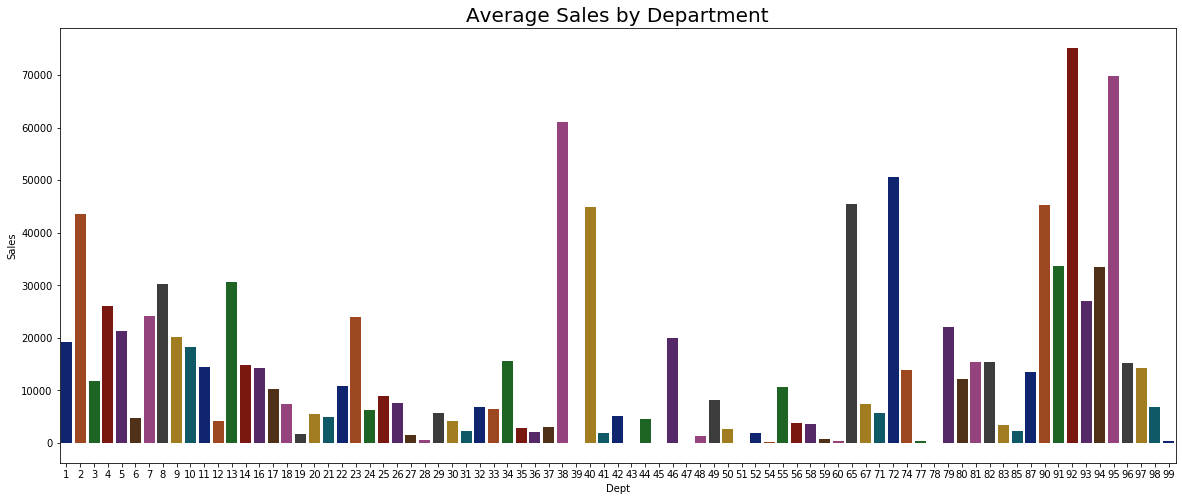

In [79]:
weekly_sales_dept = train_detail['Weekly_Sales'].groupby(train_detail['Dept']).mean()

plt.figure(figsize = (20,8))
sns.barplot(weekly_sales_dept.index, weekly_sales_dept.values, palette = 'dark')
plt.title('Average Sales by Department', fontsize=20)
plt.xlabel('Dept')
plt.ylabel('Sales')
plt.show()

# Correlation using Pearson Correlation

### Metrics

1. 0: no correlation at all
2. 0-0.3: weak correlation
3. 0.3- 0.7: moderate correlation
4. 0.7-1: strong correlation

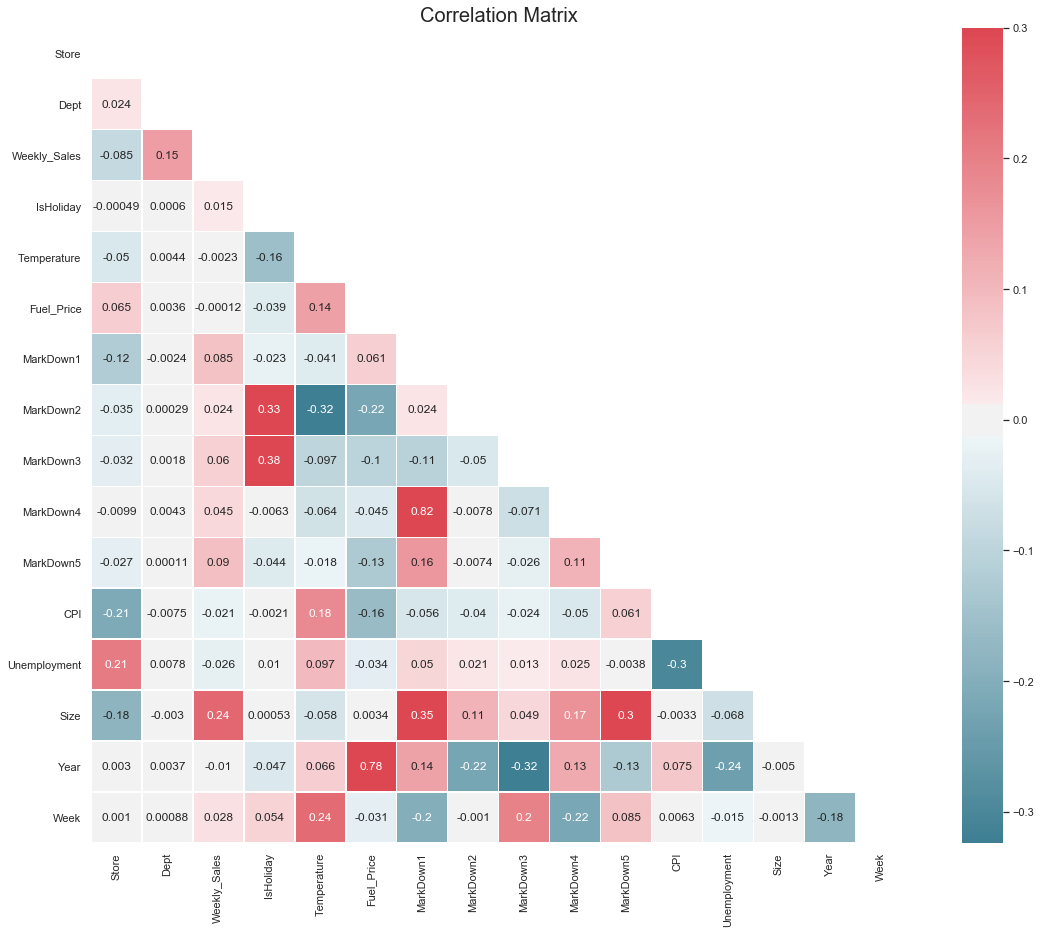

In [80]:
sns.set(style = 'white')
corr = train_detail.corr()
mask = np.triu(np.ones_like(corr, dtype = np.bool))

f, ax = plt.subplots(figsize=(20,15))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

plt.title('Correlation Matrix', fontsize = 20)
sns.heatmap(corr, mask = mask, cmap = cmap, vmax=.3, center=0, square=True, linewidths =.5, annot=True)

plt.show()

#### Since Mardown1 to 5 have low correlations to Weekly_sales as well as many null values, we can drop them.
Fuel_Price has strong correlation to Year, it must be droppped. ow they would be multilinearity

In [81]:
train_detail.drop(['Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'], axis =1, inplace = True)
test_detail.drop(['Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'], axis =1, inplace = True)

In [82]:
train_detail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
 5   Temperature   421570 non-null  float64       
 6   CPI           421570 non-null  float64       
 7   Unemployment  421570 non-null  float64       
 8   Type          421570 non-null  object        
 9   Size          421570 non-null  int64         
 10  Year          421570 non-null  int64         
 11  Week          421570 non-null  int64         
dtypes: bool(1), datetime64[ns](1), float64(4), int64(5), object(1)
memory usage: 35.8+ MB


In [83]:
train_detail.isnull().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Temperature     0
CPI             0
Unemployment    0
Type            0
Size            0
Year            0
Week            0
dtype: int64

In [84]:
test_detail.info()
test_detail.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115064 entries, 0 to 115063
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         115064 non-null  int64         
 1   Dept          115064 non-null  int64         
 2   Date          115064 non-null  datetime64[ns]
 3   IsHoliday     115064 non-null  bool          
 4   Temperature   115064 non-null  float64       
 5   CPI           76902 non-null   float64       
 6   Unemployment  76902 non-null   float64       
 7   Type          115064 non-null  object        
 8   Size          115064 non-null  int64         
 9   Year          115064 non-null  int64         
 10  Week          115064 non-null  int64         
dtypes: bool(1), datetime64[ns](1), float64(3), int64(5), object(1)
memory usage: 8.9+ MB


Store               0
Dept                0
Date                0
IsHoliday           0
Temperature         0
CPI             38162
Unemployment    38162
Type                0
Size                0
Year                0
Week                0
dtype: int64

# Discrete vs Continuous Plot for Variable Analysis

#### Discrete plot : finite numnbers using box plot to see median, min, max and outlier
Continuous plot: distribution of probabilities and use BoxCoX to understand if there's increase of correlation and decrease
    of skewness for each variable

In [89]:
def discrete_plot(feature):
    fig = plt.figure(figsize = (20,8))
    gs=GridSpec(1,2)
    sns.boxplot(x = train_detail[feature], y=train_detail['Weekly_Sales'], ax = fig.add_subplot(gs[0,0]))
    
    plt.ylabel('Sales', fontsize =16)
    plt.xlabel(feature, fontsize =16)
    
    sns.stripplot(x = train_detail[feature], y=train_detail['Weekly_Sales'], ax = fig.add_subplot(gs[0,1]))
    
    plt.ylabel('Sales', fontsize =16)
    plt.xlabel(feature, fontsize =16)
    fig.show()

In [106]:
def continuous_plot(feature):
    fig = plt.figure(figsize = (18,15))
    gs=GridSpec(2,2)
    
    j = sns.scatterplot(y=train_detail['Weekly_Sales'], 
                        x=boxcox1p(train_detail[feature], 0.15), ax=fig.add_subplot(gs[0,1]), palette = 'blue')

    plt.title('BoxCox 0.15\n' + 'Corr: ' + str(np.round(train_detail['Weekly_Sales'].corr(boxcox1p(train_detail[feature], 0.15)),2)) +
              ', Skew: ' + str(np.round(stats.skew(boxcox1p(train_detail[feature], 0.15), nan_policy='omit'),2)))
    
    j = sns.scatterplot(y=train_detail['Weekly_Sales'], 
                        x=boxcox1p(train_detail[feature], 0.25), ax=fig.add_subplot(gs[1,0]), palette = 'blue')

    plt.title('BoxCox 0.25\n' + 'Corr: ' + str(np.round(train_detail['Weekly_Sales'].corr(boxcox1p(train_detail[feature], 0.25)),2)) +
              ', Skew: ' + str(np.round(stats.skew(boxcox1p(train_detail[feature], 0.25), nan_policy='omit'),2)))
    
    j = sns.distplot(train_detail[feature], ax=fig.add_subplot(gs[1,1]), color = 'green')

    plt.title('Distribution\n')
    
    j = sns.scatterplot(y=train_detail['Weekly_Sales'], 
                        x=train_detail[feature], ax=fig.add_subplot(gs[0,0]), color = 'red')

    plt.title('Linear\n' + 'Corr: ' + str(np.round(train_detail['Weekly_Sales'].corr(train_detail[feature]),2)) + ', Skew: ' + 
               str(np.round(stats.skew(train_detail[feature], nan_policy='omit'),2)))
    
    fig.show()

# discrete plot
Weekly_Sales by IsHoliday

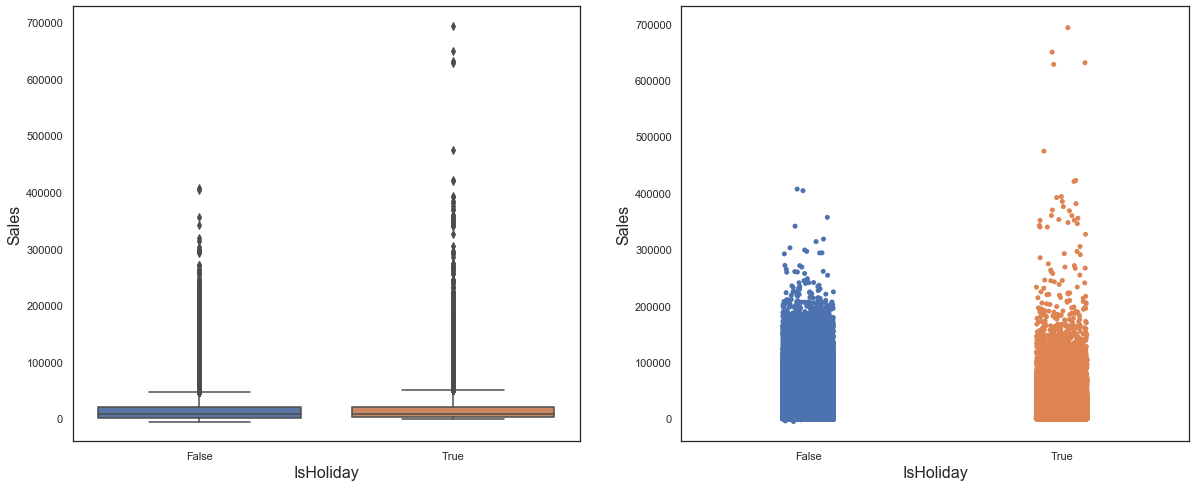

In [97]:
discrete_plot('IsHoliday')

#### Sales a lot more outliers during holidays

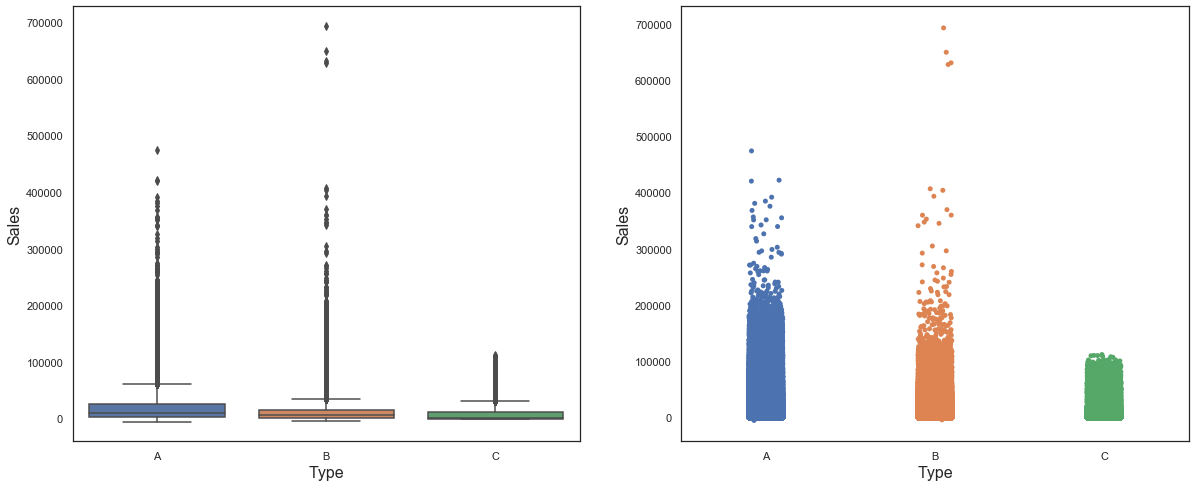

In [98]:
#Weekly_Sales by Type
discrete_plot('Type')


In [99]:
#We don't know what types represent but median of A>B>C, let's treat them as ordinal variable and replace its values

In [101]:
train_detail['Type'] = train_detail['Type'].apply(lambda x:3 if x=='A' else(2 if x =='B' else 1))
test_detail['Type'] = test_detail['Type'].apply(lambda x:3 if x=='A' else(2 if x =='B' else 1))

In [102]:
train_detail.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,CPI,Unemployment,Type,Size,Year,Week
0,1,1,2010-02-05,24924.50,False,42.31,211.096358,8.106,3,151315,2010,5
1,1,1,2010-02-12,46039.49,True,38.51,211.242170,8.106,3,151315,2010,6
2,1,1,2010-02-19,41595.55,False,39.93,211.289143,8.106,3,151315,2010,7
3,1,1,2010-02-26,19403.54,False,46.63,211.319643,8.106,3,151315,2010,8
4,1,1,2010-03-05,21827.90,False,46.50,211.350143,8.106,3,151315,2010,9


### Continuous Plot - Temperature, CPI, Unemployment, Size

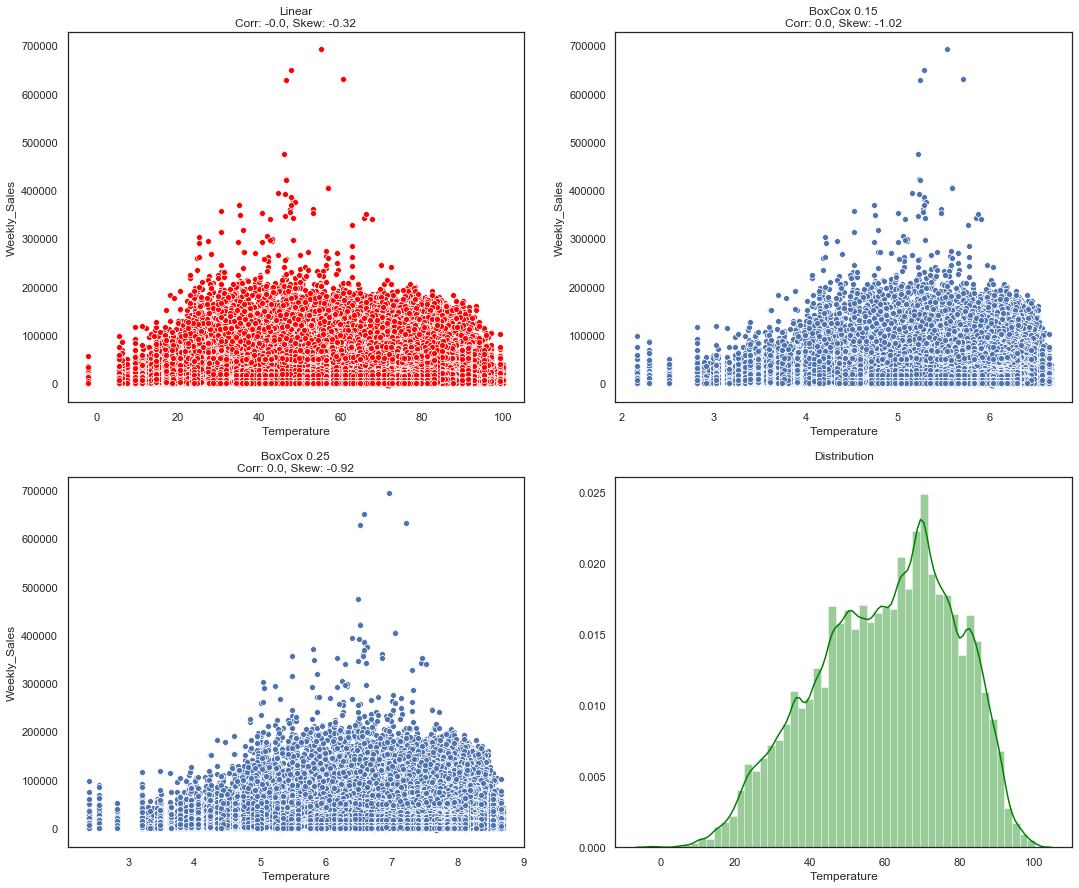

In [107]:
continuous_plot('Temperature')

#### Despite changes of skewness, correlation doesn't seem to affect. Decide to drop it

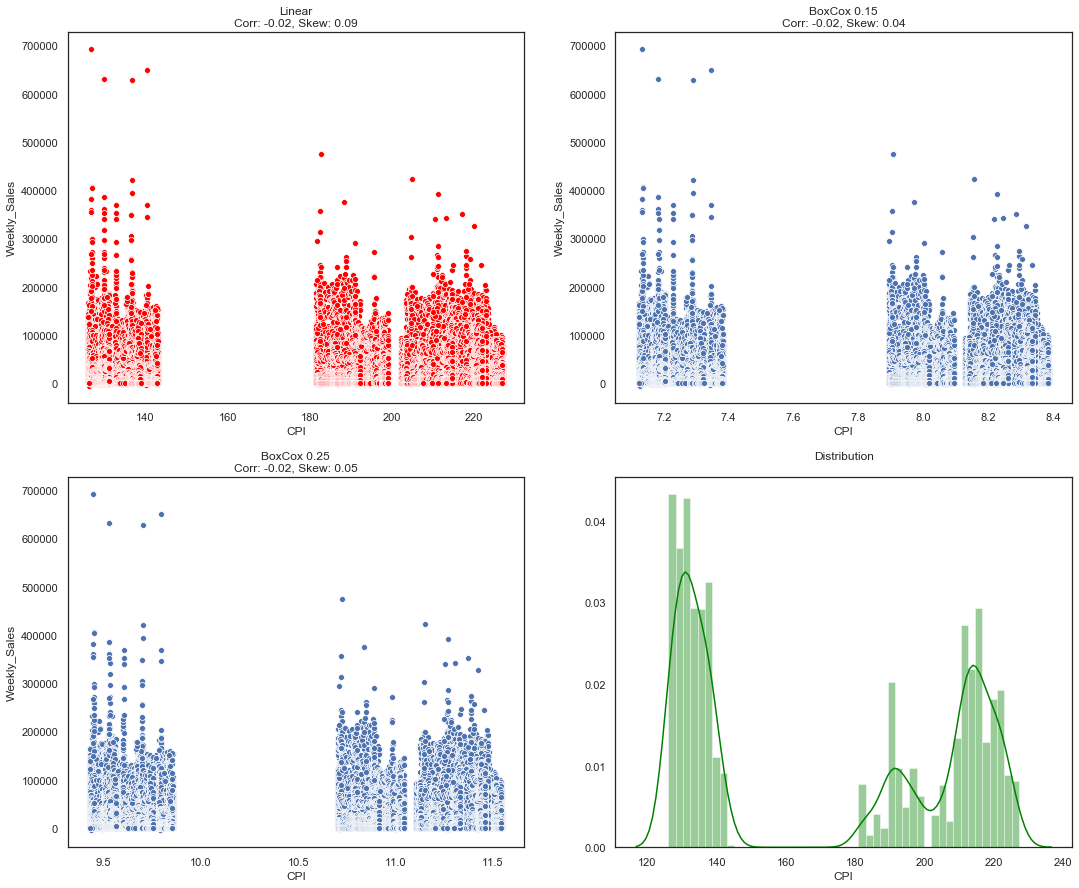

In [108]:
continuous_plot('CPI')

#### CPI won't affect weekly sales much - low correlation with weekly sales

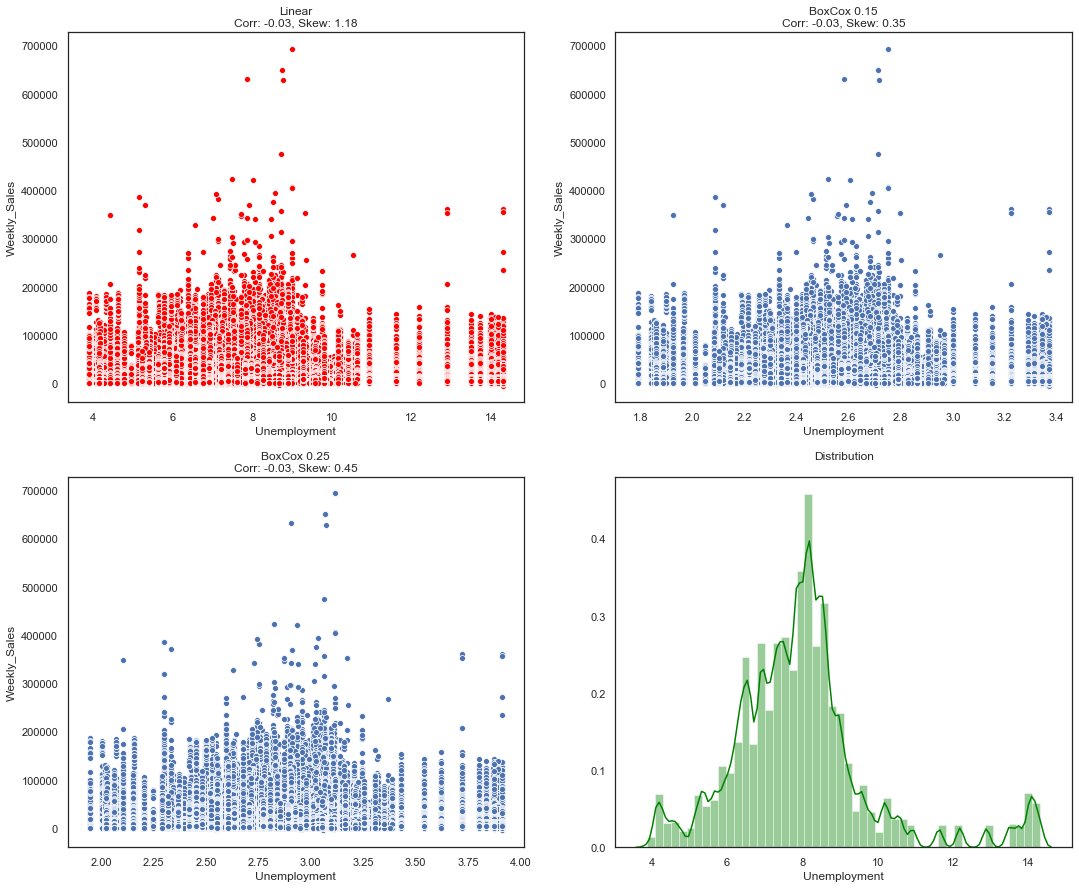

In [109]:
continuous_plot('Unemployment')

#### same for unemployment rate - drop it

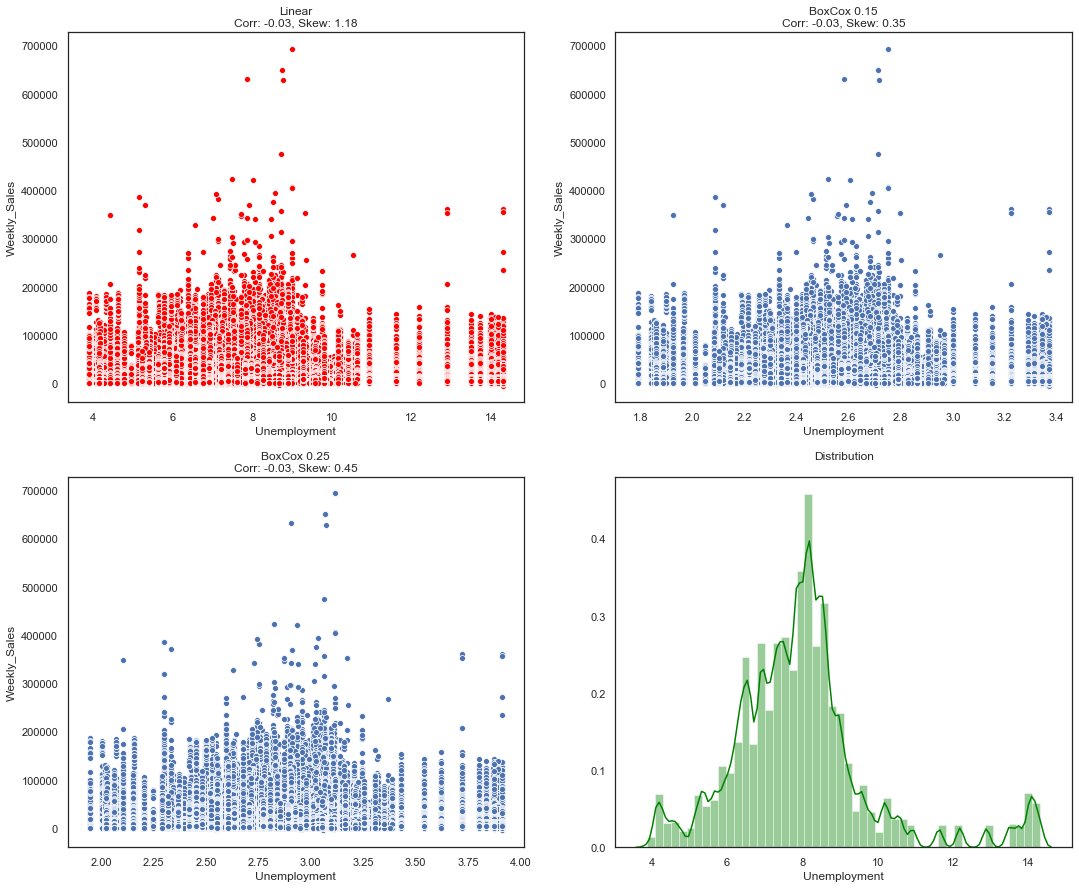

In [110]:
continuous_plot('Unemployment')

#### same for unemployment - drop it

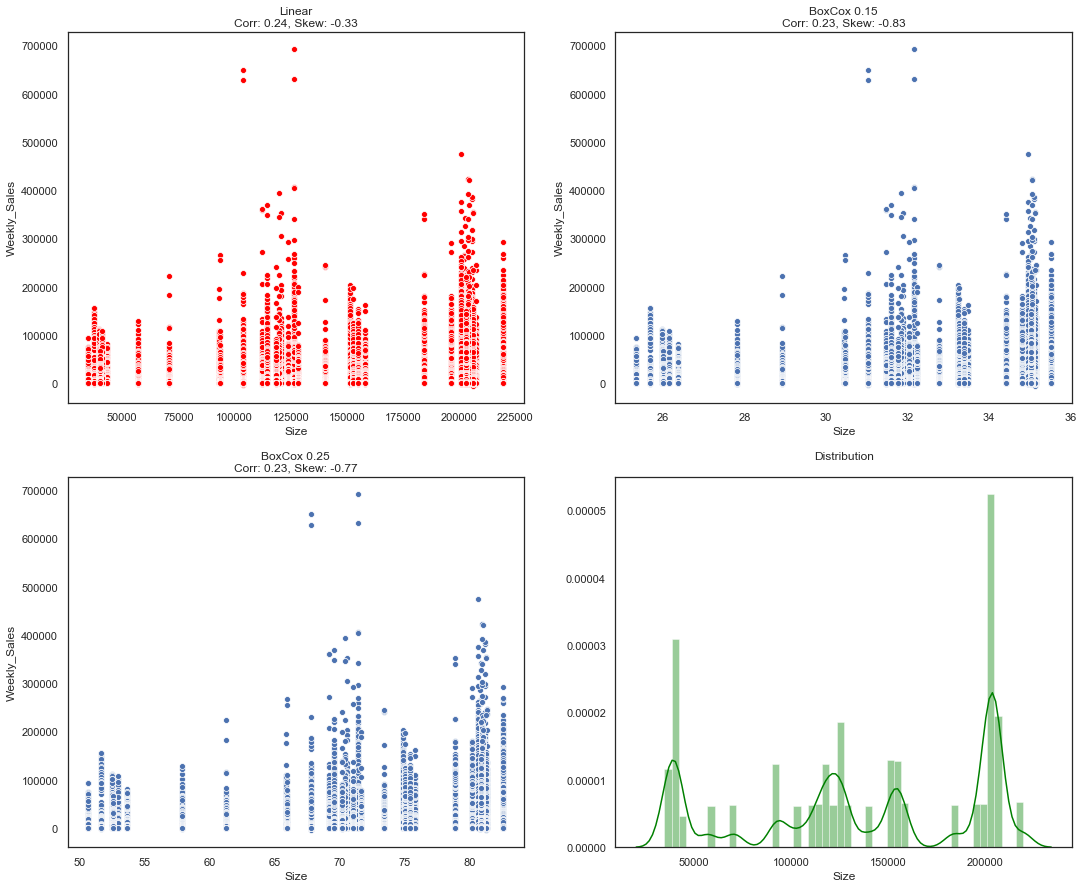

In [111]:
continuous_plot('Size')

#### Since it has correlation with sales, we'll keep them

In [112]:
train_detail.drop(['Temperature', 'CPI', 'Unemployment'], axis=1, inplace =True)
test_detail.drop(['Temperature', 'CPI', 'Unemployment'], axis=1, inplace =True)

In [113]:
train_detail.info()
train_detail.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
 5   Type          421570 non-null  int64         
 6   Size          421570 non-null  int64         
 7   Year          421570 non-null  int64         
 8   Week          421570 non-null  int64         
dtypes: bool(1), datetime64[ns](1), float64(1), int64(6)
memory usage: 26.1 MB


,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Year,Week
0,1,1,2010-02-05,24924.50,False,3,151315,2010,5
1,1,1,2010-02-12,46039.49,True,3,151315,2010,6
2,1,1,2010-02-19,41595.55,False,3,151315,2010,7
3,1,1,2010-02-26,19403.54,False,3,151315,2010,8
4,1,1,2010-03-05,21827.90,False,3,151315,2010,9


# Modelling

#### Evaluation is given by Walmart

Weighted mean absolute error (MAE)

In [114]:
def WMAE(dataset, real, predicted):
    weights = dataset.IsHoliday.apply(lambda x:5 if x else 1)
    return np.round(np.sum(weights *abs(real-predicted))/(np.sum(weights)),2)

# Use RandomForest Model

In [115]:
def random_forest(n_estimators, max_depth):
    result = []
    for estimator in n_estimators:
        for depth in max_depth:
            wmaes_cv = []
            for i in range(1,5):
                print('k:', i, ', n_estimators:', estimator, ', max_depth:', depth)
                x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.3)
                RF = RandomForestRegressor(n_estimators=estimator, max_depth=depth)
                RF.fit(x_train, y_train)
                predicted = RF.predict(x_test)
                wmaes_cv.append(WMAE(x_test, y_test, predicted))
            print('WMAE:', np.mean(wmaes_cv))
            result.append({'Max_Depth': depth, 'Estimators': estimator, 'WMAE': np.mean(wmaes_cv)})
    return pd.DataFrame(result)

In [116]:
def random_forest_II(n_estimators, max_depth, max_features):
    result = []
    for feature in max_features:
        wmaes_cv = []
        for i in range(1,5):
            print('k:', i, ', max_features:', feature)
            x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.3)
            RF = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, max_features=feature)
            RF.fit(x_train, y_train)
            predicted = RF.predict(x_test)
            wmaes_cv.append(WMAE(x_test, y_test, predicted))
        print('WMAE:', np.mean(wmaes_cv))
        result.append({'Max_Feature': feature, 'WMAE': np.mean(wmaes_cv)})
    return pd.DataFrame(result)

In [117]:
def random_forest_III(n_estimators, max_depth, max_features, min_samples_split, min_samples_leaf):
    result = []
    for split in min_samples_split:
        for leaf in min_samples_leaf:
            wmaes_cv = []
            for i in range(1,5):
                print('k:', i, ', min_samples_split:', split, ', min_samples_leaf:', leaf)
                x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.3)
                RF = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, max_features=max_features, 
                                           min_samples_leaf=leaf, min_samples_split=split)
                RF.fit(x_train, y_train)
                predicted = RF.predict(x_test)
                wmaes_cv.append(WMAE(x_test, y_test, predicted))
            print('WMAE:', np.mean(wmaes_cv))
            result.append({'Min_Samples_Leaf': leaf, 'Min_Samples_Split': split, 'WMAE': np.mean(wmaes_cv)})
    return pd.DataFrame(result)

# Train & Test model

In [118]:
X_train = train_detail[['Store', 'Dept', 'IsHoliday','Size', 'Week', 'Type', 'Year']]
Y_train = train_detail['Weekly_Sales']

### Assign n_estimator and max_depth

In [119]:
n_estimators = [56,58,60]
max_depth = [25,27,30]

random_forest(n_estimators, max_depth)

k: 1 , n_estimators: 56 , max_depth: 25
k: 2 , n_estimators: 56 , max_depth: 25
k: 3 , n_estimators: 56 , max_depth: 25
k: 4 , n_estimators: 56 , max_depth: 25
WMAE: 1539.9775
k: 1 , n_estimators: 56 , max_depth: 27
k: 2 , n_estimators: 56 , max_depth: 27
k: 3 , n_estimators: 56 , max_depth: 27
k: 4 , n_estimators: 56 , max_depth: 27
WMAE: 1541.4625
k: 1 , n_estimators: 56 , max_depth: 30
k: 2 , n_estimators: 56 , max_depth: 30
k: 3 , n_estimators: 56 , max_depth: 30
k: 4 , n_estimators: 56 , max_depth: 30
WMAE: 1547.1475
k: 1 , n_estimators: 58 , max_depth: 25
k: 2 , n_estimators: 58 , max_depth: 25
k: 3 , n_estimators: 58 , max_depth: 25
k: 4 , n_estimators: 58 , max_depth: 25
WMAE: 1550.99
k: 1 , n_estimators: 58 , max_depth: 27
k: 2 , n_estimators: 58 , max_depth: 27
k: 3 , n_estimators: 58 , max_depth: 27
k: 4 , n_estimators: 58 , max_depth: 27
WMAE: 1551.6275
k: 1 , n_estimators: 58 , max_depth: 30
k: 2 , n_estimators: 58 , max_depth: 30
k: 3 , n_estimators: 58 , max_depth: 30
k:

,Max_Depth,Estimators,WMAE
0,25,56,1539.9775
1,27,56,1541.4625
2,30,56,1547.1475
3,25,58,1550.9900
4,27,58,1551.6275
5,30,58,1551.0950
6,25,60,1540.5825
7,27,60,1566.4600
8,30,60,1554.7200


In [120]:
max_features = [2, 3, 4, 5, 6, 7]

random_forest_II(n_estimators=58, max_depth=27, max_features=max_features)

k: 1 , max_features: 2
k: 2 , max_features: 2
k: 3 , max_features: 2
k: 4 , max_features: 2
WMAE: 4552.9475
k: 1 , max_features: 3
k: 2 , max_features: 3
k: 3 , max_features: 3
k: 4 , max_features: 3
WMAE: 2706.6575
k: 1 , max_features: 4
k: 2 , max_features: 4
k: 3 , max_features: 4
k: 4 , max_features: 4
WMAE: 1806.2599999999998
k: 1 , max_features: 5
k: 2 , max_features: 5
k: 3 , max_features: 5
k: 4 , max_features: 5
WMAE: 1568.2174999999997
k: 1 , max_features: 6
k: 2 , max_features: 6
k: 3 , max_features: 6
k: 4 , max_features: 6
WMAE: 1534.2624999999998
k: 1 , max_features: 7
k: 2 , max_features: 7
k: 3 , max_features: 7
k: 4 , max_features: 7
WMAE: 1569.3449999999998


,Max_Feature,WMAE
0,2,4552.9475
1,3,2706.6575
2,4,1806.2600
3,5,1568.2175
4,6,1534.2625
5,7,1569.3450


In [121]:
min_samples_split = [2, 3, 4]
min_samples_leaf = [1, 2, 3]

random_forest_III(n_estimators=58, max_depth=27, max_features=6, 
                  min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)

k: 1 , min_samples_split: 2 , min_samples_leaf: 1
k: 2 , min_samples_split: 2 , min_samples_leaf: 1
k: 3 , min_samples_split: 2 , min_samples_leaf: 1
k: 4 , min_samples_split: 2 , min_samples_leaf: 1
WMAE: 1538.48
k: 1 , min_samples_split: 2 , min_samples_leaf: 2
k: 2 , min_samples_split: 2 , min_samples_leaf: 2
k: 3 , min_samples_split: 2 , min_samples_leaf: 2
k: 4 , min_samples_split: 2 , min_samples_leaf: 2
WMAE: 1593.695
k: 1 , min_samples_split: 2 , min_samples_leaf: 3
k: 2 , min_samples_split: 2 , min_samples_leaf: 3
k: 3 , min_samples_split: 2 , min_samples_leaf: 3
k: 4 , min_samples_split: 2 , min_samples_leaf: 3
WMAE: 1622.5075000000002
k: 1 , min_samples_split: 3 , min_samples_leaf: 1
k: 2 , min_samples_split: 3 , min_samples_leaf: 1
k: 3 , min_samples_split: 3 , min_samples_leaf: 1
k: 4 , min_samples_split: 3 , min_samples_leaf: 1
WMAE: 1549.45
k: 1 , min_samples_split: 3 , min_samples_leaf: 2
k: 2 , min_samples_split: 3 , min_samples_leaf: 2
k: 3 , min_samples_split: 3 , mi

,Min_Samples_Leaf,Min_Samples_Split,WMAE
0,1,2,1538.4800
1,2,2,1593.6950
2,3,2,1622.5075
3,1,3,1549.4500
4,2,3,1580.4800
5,3,3,1643.6675
6,1,4,1530.5825
7,2,4,1599.0775
8,3,4,1645.9425


# Final model based on the result we received above

In [122]:
RF = RandomForestRegressor(n_estimators= 58, max_depth = 27, max_features= 6, min_samples_split=3, min_samples_leaf=1)

In [123]:
RF.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=27, max_features=6, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=3, min_weight_fraction_leaf=0.0,
                      n_estimators=58, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

# Prediction

In [125]:
X_test = test_detail[['Store', 'Dept', 'IsHoliday', 'Size', 'Week', 'Type', 'Year']]
predictions = RF.predict(X_test)

In [130]:
test_detail.info()
test_detail.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115064 entries, 0 to 115063
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Store      115064 non-null  int64         
 1   Dept       115064 non-null  int64         
 2   Date       115064 non-null  datetime64[ns]
 3   IsHoliday  115064 non-null  bool          
 4   Type       115064 non-null  int64         
 5   Size       115064 non-null  int64         
 6   Year       115064 non-null  int64         
 7   Week       115064 non-null  int64         
dtypes: bool(1), datetime64[ns](1), int64(6)
memory usage: 6.3 MB


,Store,Dept,Date,IsHoliday,Type,Size,Year,Week
0,1,1,2012-11-02,False,3,151315,2012,44
1,1,1,2012-11-09,False,3,151315,2012,45
2,1,1,2012-11-16,False,3,151315,2012,46
3,1,1,2012-11-23,True,3,151315,2012,47
4,1,1,2012-11-30,False,3,151315,2012,48


# Christmas Adjustment

#### Christmas week has 0 pre-holiday in 2010, 1 in 2011, 2 in 2012 and 3 in 2012. 
2.5 days average 2.5 days average in a week. So this is the value that we are going to multiply to week 51 and add
to week 52 to compensate what the model didn't take into account



In [131]:
Final = X_test[['Store', 'Dept','Week']]
Final['Weekly_Sales'] = predictions

In [132]:
Final.head(20)

,Store,Dept,Week,Weekly_Sales
0,1,1,44,30346.401980
1,1,1,45,19019.150718
2,1,1,46,19134.926095
3,1,1,47,19715.735057
4,1,1,48,23541.333755
5,1,1,49,32003.534489
6,1,1,50,46052.920572
7,1,1,51,47645.282983
8,1,1,52,21095.432126
9,1,1,1,16448.513914


In [133]:
Final_adj = pysqldf("""
    Select 
        Store,
        Dept,
        Week,
        Weekly_Sales,
        case
            When Week =52 and last_sales > 2 * Weekly_Sales Then Weekly_Sales + (2.5/7) * last_sales
            Else Weekly_Sales
        End as Weekly_Sales_Adjusted
    From (
        Select
            Store,
            Dept,
            Week,
            Weekly_Sales,
            Case
                When Week =52 then lag(Weekly_Sales) over (Partition By Store, Dept)
            End as last_sales
        From Final)""")

In [143]:
Final_adj[['Week','Weekly_Sales','Weekly_Sales_Adjusted']].head(20)

,Week,Weekly_Sales,Weekly_Sales_Adjusted
0,44,30346.401980,30346.401980
1,45,19019.150718,19019.150718
2,46,19134.926095,19134.926095
3,47,19715.735057,19715.735057
4,48,23541.333755,23541.333755
5,49,32003.534489,32003.534489
6,50,46052.920572,46052.920572
7,51,47645.282983,47645.282983
8,52,21095.432126,38111.604620
9,1,16448.513914,16448.513914


# Submission

In [145]:
sample_submission['Weekly_Sales'] = Final_adj['Weekly_Sales_Adjusted']

In [146]:
sample_submission.head(10)

,Id,Weekly_Sales
0,1_1_2012-11-02,30346.401980
1,1_1_2012-11-09,19019.150718
2,1_1_2012-11-16,19134.926095
3,1_1_2012-11-23,19715.735057
4,1_1_2012-11-30,23541.333755
5,1_1_2012-12-07,32003.534489
6,1_1_2012-12-14,46052.920572
7,1_1_2012-12-21,47645.282983
8,1_1_2012-12-28,38111.604620
9,1_1_2013-01-04,16448.513914


In [147]:
sample_submission.to_csv('submission.csv', index=False)